### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

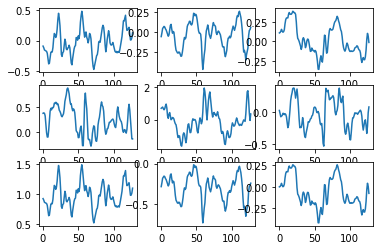

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [9]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [10]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,\
                                    Dense,\
                                    SimpleRNN

### Single Layer SimpleRNN

In [11]:
### START YOUR CODE

n_hidden_units = 32

model = Sequential()

model.add(Input(X_train[0].shape))
model.add(SimpleRNN(n_hidden_units))
model.add(Dense(N_CLASSES, activation='softmax'))

### END YOUR CODE

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1344      
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________


In [12]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50
patience = 10
clipnorm = 0.2

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), \
             optimizer=tf.keras.optimizers.Adam(clipnorm=clipnorm), \
             metrics=['accuracy'])

log = model.fit(X_train, Y_train, \
                batch_size=batch_size, \
                epochs=n_epochs, \
                validation_data=(X_test, Y_test), \
                callbacks=[early_stopping])

Epoch 1/50
58/58 [==============================] - 2s 18ms/step - loss: 1.6261 - accuracy: 0.3682 - val_loss: 1.3258 - val_accuracy: 0.5012
Epoch 2/50
58/58 [==============================] - 1s 12ms/step - loss: 1.1478 - accuracy: 0.5600 - val_loss: 1.0753 - val_accuracy: 0.5993
Epoch 3/50
58/58 [==============================] - 1s 13ms/step - loss: 0.9348 - accuracy: 0.6435 - val_loss: 1.0432 - val_accuracy: 0.6196
Epoch 4/50
58/58 [==============================] - 1s 13ms/step - loss: 0.8728 - accuracy: 0.6546 - val_loss: 0.9287 - val_accuracy: 0.6193
Epoch 5/50
58/58 [==============================] - 1s 12ms/step - loss: 0.7074 - accuracy: 0.7141 - val_loss: 1.2720 - val_accuracy: 0.5575
Epoch 6/50
58/58 [==============================] - 1s 12ms/step - loss: 0.7008 - accuracy: 0.7031 - val_loss: 0.7645 - val_accuracy: 0.6885
Epoch 7/50
58/58 [==============================] - 1s 12ms/step - loss: 0.5885 - accuracy: 0.7437 - val_loss: 0.9531 - val_accuracy: 0.6488
Epoch 8/50
58

Train accuracy (end): 0.8941784501075745
Train accuracy (max): 0.8941784501075745
Test accuracy (end) : 0.8344078660011292
Test accuracy (max) : 0.8411944508552551


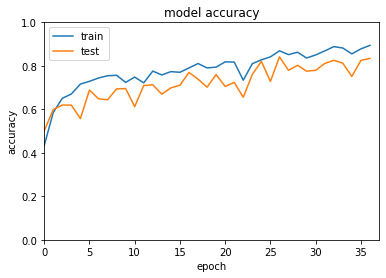

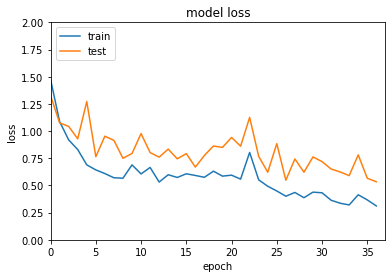

,walk,up,down,sit,stand,lay
walk,448,32,12,4,0,0
up,96,343,28,3,1,0
down,42,6,372,0,0,0
sit,0,22,1,400,68,0
stand,2,5,0,87,438,0
lay,0,27,32,0,0,478


In [13]:
performance_plots(model, X_test, Y_test, log, len(log.history['accuracy']))
confusion_matrix(model, X_test, Y_test)

#### Findings
The test-accuracy got a very good result of 84.1%. Both, the training- and the testcurves are very dynamic since the gradients make a too large step in a eventually good direction. This problem is called exploding gradients-problem and can be minimized on behalf of the clipnorm added to the optimizer. In our test, the clipnorm helped to increase the overall performance as well.

### Stacked Simple RNNs

In [14]:
### START YOUR CODE

model = Sequential()

model.add(Input(X_train[0].shape))

model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units))

model.add(Dense(N_CLASSES, activation='softmax'))

### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128, 32)           1344      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128, 32)           2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128, 32)           2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 7,782
Trainable params: 7,782
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), \
             optimizer=tf.keras.optimizers.Adam(clipnorm=clipnorm), \
             metrics=['accuracy'])

log = model.fit(X_train, Y_train, \
                batch_size=batch_size, \
                epochs=n_epochs, \
                validation_data=(X_test, Y_test), \
                callbacks=[early_stopping])

Epoch 1/50
58/58 [==============================] - 5s 57ms/step - loss: 1.5077 - accuracy: 0.4011 - val_loss: 0.8549 - val_accuracy: 0.6305
Epoch 2/50
58/58 [==============================] - 3s 58ms/step - loss: 0.7084 - accuracy: 0.6842 - val_loss: 0.7256 - val_accuracy: 0.6603
Epoch 3/50
58/58 [==============================] - 4s 61ms/step - loss: 0.6331 - accuracy: 0.7238 - val_loss: 0.7026 - val_accuracy: 0.7234
Epoch 4/50
58/58 [==============================] - 3s 60ms/step - loss: 0.4962 - accuracy: 0.8051 - val_loss: 0.6128 - val_accuracy: 0.7682
Epoch 5/50
58/58 [==============================] - 3s 58ms/step - loss: 0.4165 - accuracy: 0.8444 - val_loss: 0.5834 - val_accuracy: 0.7927
Epoch 6/50
58/58 [==============================] - 3s 59ms/step - loss: 0.3276 - accuracy: 0.8839 - val_loss: 0.4644 - val_accuracy: 0.8493
Epoch 7/50
58/58 [==============================] - 3s 57ms/step - loss: 0.2963 - accuracy: 0.8994 - val_loss: 0.6053 - val_accuracy: 0.8229
Epoch 8/50
58

Train accuracy (end): 0.9507616758346558
Train accuracy (max): 0.9507616758346558
Test accuracy (end) : 0.8859857320785522
Test accuracy (max) : 0.9022734761238098


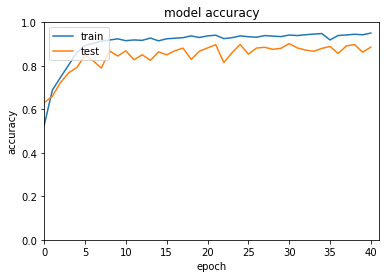

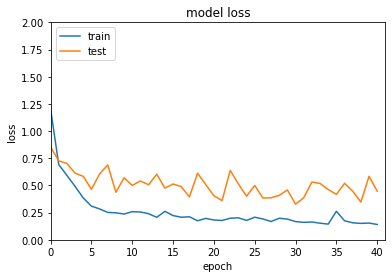

,walk,up,down,sit,stand,lay
walk,484,11,1,0,0,0
up,36,429,3,3,0,0
down,18,0,402,0,0,0
sit,0,19,0,428,44,0
stand,1,2,0,137,392,0
lay,0,13,0,0,0,524


In [16]:
performance_plots(model, X_test, Y_test, log, len(log.history['accuracy']))
confusion_matrix(model, X_test, Y_test)

#### Findings
Stacking several RNNs together and therefore increase complexity results in a slightly better test-accuracy of 90.2%, which is an improvement of about 5%

### Several CNN Layers

In [17]:
### START YOUR CODE
from tensorflow.keras.layers import InputLayer, \
                                    Conv1D, \
                                    Dropout, \
                                    Flatten

clipnorm = 0.1
dropout_rate = 0.2

model = Sequential()

model.add(InputLayer(input_shape=X_train[0].shape))

model.add(Conv1D(filters=16,
                 kernel_size=5,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=32,
                 kernel_size=3,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=64,
                 kernel_size=3,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=64,
                 kernel_size=3,
                 strides=2,
                 activation='relu'))

model.add(Flatten())

model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', \
                  optimizer=tf.keras.optimizers.Adam(clipnorm=clipnorm), \
                  metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 62, 16)            736       
_________________________________________________________________
dropout (Dropout)            (None, 62, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 64)            6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 64)            

In [18]:
### START YOUR CODE

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), \
             optimizer=tf.keras.optimizers.Adam(clipnorm=clipnorm), \
             metrics=['accuracy'])

log = model.fit(X_train, Y_train, \
                batch_size=batch_size, \
                epochs=n_epochs, \
                validation_data=(X_test, Y_test), \
                callbacks=[early_stopping])


Epoch 1/50
58/58 [==============================] - 1s 8ms/step - loss: 1.5265 - accuracy: 0.3420 - val_loss: 0.7726 - val_accuracy: 0.6664
Epoch 2/50
58/58 [==============================] - 0s 5ms/step - loss: 0.5766 - accuracy: 0.7436 - val_loss: 0.7706 - val_accuracy: 0.7441
Epoch 3/50
58/58 [==============================] - 0s 6ms/step - loss: 0.4125 - accuracy: 0.8321 - val_loss: 0.7521 - val_accuracy: 0.7859
Epoch 4/50
58/58 [==============================] - 0s 6ms/step - loss: 0.3233 - accuracy: 0.8745 - val_loss: 0.7263 - val_accuracy: 0.8225
Epoch 5/50
58/58 [==============================] - 0s 5ms/step - loss: 0.2552 - accuracy: 0.9058 - val_loss: 0.7178 - val_accuracy: 0.8551
Epoch 6/50
58/58 [==============================] - 0s 6ms/step - loss: 0.2273 - accuracy: 0.9109 - val_loss: 0.6596 - val_accuracy: 0.8653
Epoch 7/50
58/58 [==============================] - 0s 5ms/step - loss: 0.1902 - accuracy: 0.9220 - val_loss: 0.6733 - val_accuracy: 0.8636
Epoch 8/50
58/58 [==

Train accuracy (end): 0.9506256580352783
Train accuracy (max): 0.9537540674209595
Test accuracy (end) : 0.8893790245056152
Test accuracy (max) : 0.9005768299102783


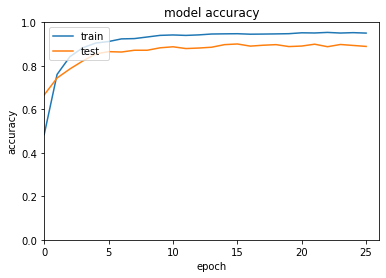

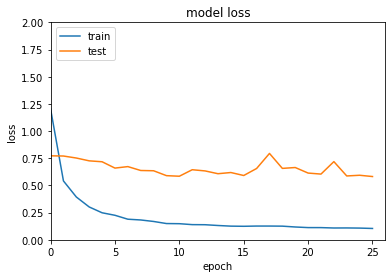

,walk,up,down,sit,stand,lay
walk,480,3,13,0,0,0
up,8,430,33,0,0,0
down,8,13,399,0,0,0
sit,0,22,0,371,95,3
stand,0,3,0,65,464,0
lay,0,27,0,0,0,510


In [21]:
performance_plots(model, X_test, Y_test, log, len(log.history['accuracy']))
confusion_matrix(model, X_test, Y_test)

#### Findings
The CNN has much more parameters (23'174) compared to the stacked RNNs (7'782), but trains much faster (Why?) and achieves a very comparable performance of 90.1%


### Mixed CNN and RNN

In [31]:
### START YOUR CODE

model = Sequential()

model.add(InputLayer(input_shape=X_train[0].shape))

model.add(Conv1D(filters=16,
                 kernel_size=5,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=32,
                 kernel_size=5,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=64,
                 kernel_size=5,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=128,
                 kernel_size=5,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv1D(filters=256,
                 kernel_size=5,
                 strides=2,
                 activation='relu'))
model.add(Dropout(dropout_rate))

model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units, return_sequences=True))
model.add(SimpleRNN(n_hidden_units))

model.add(Flatten())
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', \
                  optimizer=tf.keras.optimizers.Adam(clipnorm=clipnorm), \
                  metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 62, 16)            736       
_________________________________________________________________
dropout_20 (Dropout)         (None, 62, 16)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 29, 32)            2592      
_________________________________________________________________
dropout_21 (Dropout)         (None, 29, 32)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 13, 64)            10304     
_________________________________________________________________
dropout_22 (Dropout)         (None, 13, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 5, 128)          

In [32]:
### START YOUR CODE

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), \
             optimizer=tf.keras.optimizers.Adam(clipnorm=clipnorm), \
             metrics=['accuracy'])

log = model.fit(X_train, Y_train, \
                batch_size=batch_size, \
                epochs=n_epochs, \
                validation_data=(X_test, Y_test), \
                callbacks=[early_stopping])


Epoch 1/50
58/58 [==============================] - 2s 14ms/step - loss: 1.2929 - accuracy: 0.4635 - val_loss: 0.8126 - val_accuracy: 0.6322
Epoch 2/50
58/58 [==============================] - 0s 8ms/step - loss: 0.5766 - accuracy: 0.7452 - val_loss: 0.6422 - val_accuracy: 0.7231
Epoch 3/50
58/58 [==============================] - 0s 8ms/step - loss: 0.3907 - accuracy: 0.8370 - val_loss: 0.4513 - val_accuracy: 0.8412
Epoch 4/50
58/58 [==============================] - 1s 9ms/step - loss: 0.2906 - accuracy: 0.8895 - val_loss: 0.3258 - val_accuracy: 0.8921
Epoch 5/50
58/58 [==============================] - 0s 8ms/step - loss: 0.2092 - accuracy: 0.9215 - val_loss: 0.3890 - val_accuracy: 0.8707
Epoch 6/50
58/58 [==============================] - 0s 8ms/step - loss: 0.1742 - accuracy: 0.9322 - val_loss: 0.2691 - val_accuracy: 0.9138
Epoch 7/50
58/58 [==============================] - 0s 8ms/step - loss: 0.1555 - accuracy: 0.9392 - val_loss: 0.2607 - val_accuracy: 0.9145
Epoch 8/50
58/58 [=

Train accuracy (end): 0.9617791175842285
Train accuracy (max): 0.9623231887817383
Test accuracy (end) : 0.910417377948761
Test accuracy (max) : 0.9290804266929626


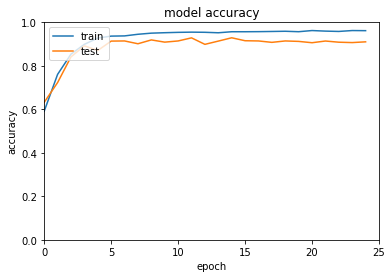

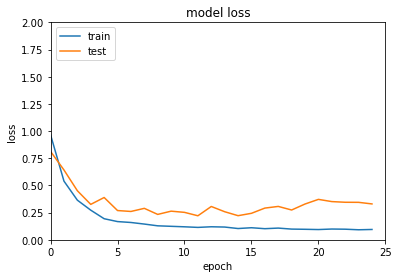

,walk,up,down,sit,stand,lay
walk,481,7,8,0,0,0
up,0,459,12,0,0,0
down,0,0,420,0,0,0
sit,0,8,0,414,67,2
stand,1,0,0,104,427,0
lay,0,0,0,0,0,537


In [34]:
performance_plots(model, X_test, Y_test, log, len(log.history['accuracy']))
confusion_matrix(model, X_test, Y_test)

#### Findings
The mixed CNN and RNN model outperformes the CNN- or RNN-only models as expected. The test-accuracy could be improved by about 3%, which results in an overall performance of around 93%. This proves our expectation, that combined models are always stronger than one of those models alone -> This technique is very well known in the literature and is called bagging.